In [1]:
import sys
sys.path.insert(1, "../python/architecture")
sys.path.insert(2, "../python/functions")

In [2]:
import numpy as np
from inverse_problem_functions import y_noise
from enkf_functions import enkf_inverse_problem
from plotting_functions import plot_IP_loss_evolution, plot_IP_loss_evolution_many, plot_IP_true_false, plot_IP_particle_loss, plot_IP_particle_std, plot_IP_iteration_std
from sklearn.metrics import mean_squared_error

In [54]:
def enkf_linear_inverse_problem_analysis(setting_dict,
                                         analysis_dict
                                         ):

    """ Ensemble Kalman Filter algorithm applied to a linear inverse problem with analysis options.


    Parameters:

    setting_dict (dict): Dictionary containing
        A (np.ndarray): Matrix A for the model Ax = y + noise.
        model_func (function): Function to apply to x.
        x (np.array): True parameters.
        y (np.array): True target variable.
        particles (int): Number of particles in the ensemble.
        epochs (int): Number of epochs.
        noise (bool): Whether or not to add noise to the target variable.
        std (np.array): Standard deviation of the noise.
        h_0 (int or float): Starting step size.
        epsilon (float): Constant for numerical stability in the step size.
        randomization (bool): Whether or not to add noise to the particles and randomize them around their mean.
        loss (str): Which kind of loss to use. Can be either "mse" or "rel_mse"
    analysis_dict (dict or None): Dictionary containing
        disjoint_batch (bool): Whether or not to use disjoint batches. If False then each batch is sampled with replacement.
        batch_particle_connection (dict): Dictionary containing
            connect (bool): Whether or not to connect particles and batches.
            shuffle (str or None): Whether or not and how to shuffle the connection. None = no shuffle. "batch" = shuffle the batch for fixed particle sets. "full" = shuffle the particle sets and their corresponding batch.
            update_all (bool): Whether or not to update after all particles have seen some data.
        tikhonov (dict): Dictionary containing
            regularize (bool): Whether or not to use Tikhonov regularization.
            lambda (None or float): Lambda parameter in Tikhonov regularization.
            reg_mse_stop (bool): Whether or not to stop when MSE + Tikhonov regularization starts to rise again.
        batch_evaluation (bool): Whether or not to compute the MSE after each batch. Only possible if no batch_particle_connection ist performed.


    Returns:
    
    return_dict (dict): Dictionary containing
        final_params (np.ndarray): Final predicted parameter.
        loss_evolution (list): Evolution of the loss value over each epoch.
        loss_evolution_single_dict (dict): Evolutions of loss values of all particles.
        batch_particle_dict (dict or None): Dictionary with the final batch-particle-connection.
        param_init_dict (dict): Dictionary with the initial parameter estimates for each particle.
        param_dict (dict): Dictionary with the final parameter estimates for each particle.
        A (np.ndarray): Matrix A for the model Ax = y + noise.
        y (np.array): True target variable.
        A_batches (list): List of all final batches of the matrix A.
        y_batches (list): List of all final batches of the target variable y.
        

    """

    A = setting_dict["A"]
    model_func = setting_dict["model_func"]
    x = setting_dict["x"]
    y = setting_dict["y"]
    particles = setting_dict["particles"]
    epochs = setting_dict["epochs"]
    batch_size = setting_dict["batch_size"]
    noise = setting_dict["noise"]
    std = setting_dict["std"]
    h_0 = setting_dict["h_0"]
    epsilon = setting_dict["epsilon"]
    randomization = setting_dict["randomization"]
    loss_type = setting_dict["loss"]
    
    if analysis_dict is None:
        disjoint_batch = True
        batch_particle_connection = False
        batch_particle_shuffle = None
        update_all = False
        tik_regularize = False
        tik_lambda = 0
        reg_mse_stop = False
        reg_stop = False
        batch_mse = False
    else:
        disjoint_batch = analysis_dict["disjoint_batch"]
        batch_particle_connection = analysis_dict["batch_particle_connection"]["connect"]
        batch_particle_shuffle = analysis_dict["batch_particle_connection"]["shuffle"]
        update_all = analysis_dict["batch_particle_connection"]["update_all"]
        tik_regularize = analysis_dict["tikhonov"]["regularize"]
        tik_lambda = analysis_dict["tikhonov"]["lambda"]
        reg_mse_stop = analysis_dict["tikhonov"]["reg_mse_stop"]
        reg_stop = False
        batch_mse = analysis_dict["batch_evaluation"]
    
    if batch_size == A.shape[0] and batch_mse == True:
        batch_mse = False
    
    if tik_lambda is None:
        tik_lambda = 0

    if noise and std is None:
        raise ValueError("If noise is True, then std can not be None.")
        
    if noise:
        gamma_HM12 = np.sqrt(np.linalg.inv(np.diag(std)))
    else:
        gamma_HM12 = None
        
    def model_func(mat, param):
        if tik_regularize:
            mat = np.vstack([mat, tik_lambda * np.identity(n = param.shape[0])])
        return np.dot(mat, param)

    def loss(y_true, y_pred, reg, gamma_HM12):
        if tik_regularize:
            y_true = np.hstack([y_true, np.zeros(shape = (y_pred.shape[0] - y_true.shape[0],))])
        if not noise:
            if loss_type == "mse":
                if not tik_regularize:
                    return mean_squared_error(y_true, y_pred)
                else:
                    return mean_squared_error(y_true, y_pred) + tik_lambda * np.sum(reg**2)
            elif loss_type == "rel_mse":
                if not tik_regularize:
                    return mean_squared_error(y_true, y_pred) / np.mean(y_true)
                else:
                    return mean_squared_error(y_true, y_pred) / np.mean(y_true) + tik_lambda * np.sum(reg**2)
        else:
            if loss_type == "mse":
                if not tik_regularize:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2)
                else:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2) + tik_lambda * np.sum(reg**2)
            elif loss_type == "rel_mse":
                if not tik_regularize:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2) / np.mean(y_true)
                else:
                    return np.mean(np.dot(gamma_HM12, y_true - y_pred)**2) / np.mean(y_true) + tik_lambda * np.sum(reg**2)

    def grad_loss(y_true, y_pred, gamma_HM12):
        if tik_regularize:
            y_true = np.hstack([y_true, np.zeros(shape = (y_pred.shape[0] - y_true.shape[0],))])
        if not noise:
            return (-2) / y_true.shape[0] * (y_true - y_pred)
        else:
            return (-2) / y_true.shape[0] * np.diag(gamma_HM12) * (y_true - y_pred)
        
    if batch_size is None:
        batch_size = A.shape[0]
        
    if disjoint_batch:
        n = A.shape[0]
        num_batches = int(np.ceil(n / batch_size))
        batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
        batch_indices[-1] = n
    else:
        n = A.shape[0]
        num_batches = int(np.ceil(n / batch_size))
        last_batch_size = n % batch_size
    
    indices = np.arange(n)
    if disjoint_batch:
        A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        if noise:
            gamma_batches = [gamma_HM12[indices][int(batch_indices[i]):int(batch_indices[i+1]), int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
    else:
        if last_batch_size != 0:
            indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches-1)]
            indices.append(np.random.choice(A.shape[0], size = last_batch_size, replace = True))
        else:
            indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches)]
        A_batches = [A[indices[i]] for i in range(len(indices))]
        y_batches = [y[indices[i]] for i in range(len(indices))]
        if noise:
            gamma_batches = [gamma_HM12[indices[i], indices[i]] for i in range(len(indices))]
    
    if batch_particle_connection:
        batch_particle_dict = {}
        batch_particle_indices = np.arange(particles) + 1
        np.random.shuffle(batch_particle_indices)
        if particles == num_batches:
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
        elif particles > num_batches:
            base_batches = particles // num_batches
            add_batches = particles % num_batches
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                batch_particle_indices = batch_particle_indices[base_batches:]
            for i in range(add_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
        elif num_batches > particles:
            num_reps = int(np.ceil(num_batches / particles))
            particles_repeated = np.tile(batch_particle_indices, num_reps)
            for i in range(num_batches):
                batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
    else:
        batch_particle_dict = None
                
    param_dict = {}
    param_init_dict = {}
    y_pred_dict = {}
    jacobian_dict = {}
    loss_dict = {}

    for i in range(particles):
        param_dict["particle_{}".format(i+1)] = np.random.normal(loc = 0, scale = 1, size = x.shape)
        param_init_dict["particle_{}".format(i+1)] = param_dict["particle_{}".format(i+1)]
        y_pred_dict["particle_{}".format(i+1)] = model_func(A, param_dict["particle_{}".format(i+1)])
        jacobian_dict["particle_{}".format(i+1)] = grad_loss(y, y_pred_dict["particle_{}".format(i+1)], gamma_HM12)
        loss_dict["particle_{}".format(i+1)] = loss(y, y_pred_dict["particle_{}".format(i+1)], param_dict["particle_{}".format(i+1)], gamma_HM12)

    param_mean = np.mean(list(param_dict.values()), axis = 0)
    final_params = param_mean

    loss_evolution = []
    loss_evolution.append(loss(y, np.dot(A, param_mean), param_dict["particle_{}".format(i+1)], gamma_HM12))
    if tik_regularize and reg_mse_stop:
        loss_evolution_reg = []
        loss_evolution_reg.append(loss(y, model_func(A, param_mean), param_dict["particle_{}".format(i+1)], gamma_HM12))

    loss_evolution_single_dict = {}
    for i in range(particles):
        loss_evolution_single_dict["particle_{}".format(i+1)] = [loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), param_dict["particle_{}".format(i+1)], gamma_HM12)]

    for epoch in range(epochs):
        
        if tik_regularize and reg_mse_stop:
            if epoch >= 1:
                if loss_evolution_reg[epoch] > loss_evolution_reg[epoch-1]:
                    reg_stop = True
                    print("Loss containing Tikhonov regularization starts to rise. Algorithm is stopped after epoch {}.".format(epoch))
                    break
                    
        if batch_particle_connection and batch_particle_shuffle == "permute": 
            shuffled_indices = np.hstack(list(batch_particle_dict.values()))
            np.random.shuffle(shuffled_indices)
            batch_particle_values = list(batch_particle_dict.values())
            for i in range(len(batch_particle_values)):
                batch_particle_dict["batch_{}".format(str(i+1))] = shuffled_indices[i*len(batch_particle_values[i]):(i+1)*len(batch_particle_values[i])]        
        if batch_particle_connection and (batch_particle_shuffle == "particle" or batch_particle_shuffle == "full"): 
            batch_particle_dict = {}
            batch_particle_indices = np.arange(particles) + 1
            np.random.shuffle(batch_particle_indices)
            if particles == num_batches:
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[i]
            elif particles > num_batches:
                base_batches = particles // num_batches
                add_batches = particles % num_batches
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = batch_particle_indices[:base_batches]
                    batch_particle_indices = batch_particle_indices[base_batches:]
                for i in range(add_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = np.concatenate([batch_particle_dict["batch_{}".format(str(i+1))], np.array([batch_particle_indices[i]])])
            elif num_batches > particles:
                num_reps = int(np.ceil(num_batches / particles))
                particles_repeated = np.tile(batch_particle_indices, num_reps)
                for i in range(num_batches):
                    batch_particle_dict["batch_{}".format(str(i+1))] = particles_repeated[i]
        if batch_particle_connection and (batch_particle_shuffle == "batch" or batch_particle_shuffle == "full"):
            indices = np.arange(n)
            np.random.shuffle(indices)
            if disjoint_batch:
                A_batches = [A[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
                y_batches = [y[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
                if noise:
                    gamma_batches = [gamma_HM12[indices][int(batch_indices[i]):int(batch_indices[i+1]), int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
            else:
                if last_batch_size != 0:
                    indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches-1)]
                    indices.append(np.random.choice(A.shape[0], size = last_batch_size, replace = True))
                else:
                    indices = [np.random.choice(A.shape[0], size = batch_size, replace = True) for i in range(num_batches)]
                A_batches = [A[indices[i]] for i in range(len(indices))]
                y_batches = [y[indices[i]] for i in range(len(indices))]
                if noise:
                    gamma_batches = [gamma_HM12[indices[i], indices[i]] for i in range(len(indices))]
                
        for b in range(num_batches):
            batch_particles = []
            y_pred_batch_dict = {}
            jacobian_batch_dict = {}
            # update the predictions, jacobian and loss for the new parameters
            for i in range(particles):
                if batch_particle_connection: 
                    if num_batches == particles or num_batches > particles:
                        if batch_particle_dict["batch_{}".format(str(b+1))] != i+1:
                            continue
                    else:
                        if i+1 not in batch_particle_dict["batch_{}".format(str(b+1))]:
                            continue
                if batch_particle_connection:
                    batch_particles.append(i+1)
                
                if noise:
                    gamma_HM12_batch = gamma_batches[b]
                else:
                    gamma_HM12_batch = None
                    
                y_pred_dict["particle_{}".format(i+1)] = model_func(A_batches[b], param_dict["particle_{}".format(i+1)])
                y_pred_batch_dict["particle_{}".format(i+1)] = y_pred_dict["particle_{}".format(i+1)]
                jacobian_dict["particle_{}".format(i+1)] = grad_loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)], gamma_HM12_batch)
                jacobian_batch_dict["particle_{}".format(i+1)] = jacobian_dict["particle_{}".format(i+1)]
                loss_dict["particle_{}".format(i+1)] = loss(y_batches[b], y_pred_dict["particle_{}".format(i+1)], param_dict["particle_{}".format(i+1)], gamma_HM12_batch)

            if not batch_particle_connection:
                # compute the mean of the predictions
                y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
                
                # compute the matrix D elementwise
                d = np.zeros(shape = (particles, particles))
                for k in range(particles):
                    y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
                    #print(np.linalg.norm(y_pred_centered))
                    for j in range(particles):
                        d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
                    #print(np.linalg.norm(jacobian_dict["particle_{}".format(str(k+1))]))
                d = np.transpose(d)

                # compute the scalar h_t
                h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
                #print(h_t)
                # matrix with particle parameters as row vectors
                params_all_ptcls = np.array(list(param_dict.values()))
                
                # compute the matrix with the updates for each particle
                params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
                
                # write the updates back into the dictionary
                for i in range(particles):
                    param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
                    
                if batch_mse:
                    param_mean = np.mean(params_all_ptcls, axis = 0)
                    loss_evolution.append(loss(y, np.dot(A, param_mean), 0, gamma_HM12))
                        
            elif batch_particle_connection and not update_all:  
                # compute the mean of the predictions
                y_pred_mean = np.mean(list(y_pred_batch_dict.values()), axis = 0)
                
                # compute the matrix D elementwise
                d = np.zeros(shape = (len(y_pred_batch_dict), len(y_pred_batch_dict)))
                for k in range(len(y_pred_batch_dict)):
                    y_pred_centered = list(y_pred_batch_dict.values())[k] - y_pred_mean
                    for j in range(len(y_pred_batch_dict)):
                        d[k][j] = np.dot(y_pred_centered, list(jacobian_batch_dict.values())[j])
                d = np.transpose(d)

                # compute the scalar h_t
                h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

                # matrix with particle parameters as row vectors
                param_batch_dict = {}
                for i in range(len(batch_particles)):
                    param_batch_dict["particle_{}".format(batch_particles[i])] = param_dict["particle_{}".format(batch_particles[i])]
                    params_all_ptcls = np.array(list(param_batch_dict.values()))
                
                # compute the matrix with the updates for each particle
                params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
                
                # write the updates back into the dictionary
                for i in range(len(batch_particles)):
                    param_dict["particle_{}".format(batch_particles[i])] = params_all_ptcls[i]
                        
        if batch_particle_connection and update_all:
            # compute the mean of the predictions
            y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

            # compute the matrix D elementwise
            d = np.zeros(shape = (particles, particles))
            for k in range(particles):
                y_pred_centered = y_pred_dict["particle_{}".format(str(k+1))] - y_pred_mean
                #print(np.linalg.norm(y_pred_centered))
                for j in range(particles):
                    d[k][j] = np.dot(y_pred_centered, jacobian_dict["particle_{}".format(str(j+1))])
                #print(np.linalg.norm(jacobian_dict["particle_{}".format(str(k+1))]))
            d = np.transpose(d)

            # compute the scalar h_t
            h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
            #print(h_t)

            # matrix with particle parameters as row vectors
            params_all_ptcls = np.array(list(param_dict.values()))

            # compute the matrix with the updates for each particle
            params_all_ptcls = params_all_ptcls - h_t * np.dot(d, params_all_ptcls)
            
            # write the updates back into the dictionary
            for i in range(particles):
                param_dict["particle_{}".format(str(i+1))] = params_all_ptcls[i]
            
        # compute loss for the parameter means
        if not batch_particle_connection and batch_mse:
            continue
        param_mean = np.mean(params_all_ptcls, axis = 0)
        loss_evolution.append(loss(y, np.dot(A, param_mean), 0, 1))
        if tik_regularize and reg_mse_stop:
            loss_evolution_reg.append(loss(y, model_func(A, param_mean), param_mean, 1))

        for i in range(particles):
            loss_evolution_single_dict["particle_{}".format(i+1)].append(loss(y, np.dot(A, param_dict["particle_{}".format(i+1)]), 0, 1))    
                    
    if not reg_stop:
        final_params = param_mean
        
    return_dict = {}
    return_dict["final_params"] = final_params
    return_dict["loss_evolution"] = loss_evolution
    return_dict["loss_evolution_single_dict"] = loss_evolution_single_dict
    return_dict["batch_particle_dict"] = batch_particle_dict
    return_dict["param_init_dict"] = param_init_dict
    return_dict["param_dict"] = param_dict
    return_dict["A"] = A
    return_dict["y"] = y
    return_dict["A_batches"] = A_batches
    return_dict["y_batches"] = y_batches

    return return_dict

# Lineares Modell

## Modell:
$Ax=y$ mit $A$ $m\times n$-Matrix, $m$, $n$ beliebig ($A$ also insbesondere nicht zwingend quadratisch).

$x$ wird gesucht.

In [35]:
A = np.random.uniform(size = (1000, 100), low = 0, high = 1)
x = np.random.uniform(size = (A.shape[1], ))

In [36]:
def model_func(x):
    return np.dot(A, x)

In [37]:
noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

In [50]:
setting_dict = {"A": A,
                "model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "epochs": 20,
                "batch_size" : 200,     # A.shape[0]           
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 3,
                "randomization": False,
                "loss": "mse"
                }
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": True,
                                               "shuffle": "full",       # None, "full", "batch", "particle", "permute"
                                               "update_all": True},
                 "tikhonov": {"regularize": False,
                              "lambda": 0,
                              "reg_mse_stop": False},
                 "batch_evaluation": False}

No handles with labels found to put in legend.


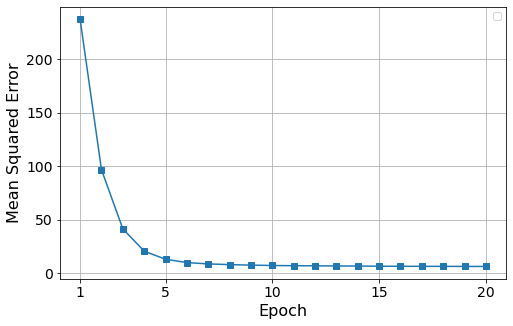

[6.961851214007695, 6.85894063534843, 6.722388552446522, 6.637704747365821, 6.4938292355743865, 6.425160761019586, 6.393493051650911, 6.352162028577734, 6.305820278489095, 6.2805929587969205]

{'batch_1': array([17, 36, 40, 23, 13, 39, 43,  8, 18, 50]), 'batch_2': array([46,  1, 10, 22, 12, 25, 35, 14, 49, 47]), 'batch_3': array([21, 29, 28, 32, 38, 27, 48, 30,  9, 19]), 'batch_4': array([33,  3, 42,  6, 20, 15, 24, 41, 31,  4]), 'batch_5': array([26, 34, 44,  7, 16, 45,  2, 11,  5, 37])}


In [55]:
return_dict = enkf_linear_inverse_problem_analysis(setting_dict,
                                                   analysis_dict)
plot_IP_loss_evolution(return_dict,
                       start_iteration = 1,
                       reg_line = False,
                       xlabel = "Epoch",
                       save = None)#"../img/inverse_problem/loss_single_linear_Noise.png")
print(return_dict["loss_evolution"][-10:])
print("")
print(return_dict["batch_particle_dict"])

In [42]:
final_params = return_dict["final_params"]
loss_evolution = return_dict["loss_evolution"]
loss_evolution_single_dict = return_dict["loss_evolution_single_dict"]
batch_particle_dict = return_dict["batch_particle_dict"]
param_init_dict = return_dict["param_init_dict"]
param_dict = return_dict["param_dict"] 
A_batches = return_dict["A_batches"]
y_batches = return_dict["y_batches"] 

Substituting symbol G from STIXNonUnicode
Substituting symbol G from STIXNonUnicode


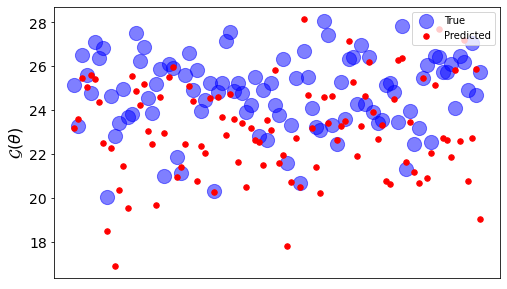

In [20]:
plot_IP_true_false(setting_dict,
                   final_params,
                   num_points = 100,
                   x_axis = False,
                   save = None)#"../img/inverse_problem/true_pred_linear_Noise.png")

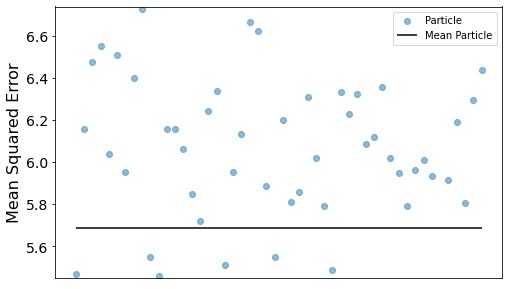

In [21]:
plot_IP_particle_loss(loss_evolution,
                      loss_evolution_single_dict,
                      rel_limit_exceed = 0.002,
                      save = None)#"../img/inverse_problem/particles_linear_Noise.png")

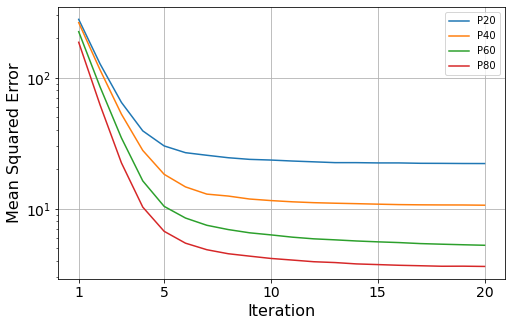

In [22]:
particle_list = [20, 40, 60, 80]

plot_IP_loss_evolution_many(setting_dict,
                            particle_list,
                            start_iteration = 1,
                            end_iteration = setting_dict["epochs"],
                            log = True,
                            xlabel = "Iteration",
                            analysis_dict = analysis_dict,
                            save = None)#"../img/inverse_problem/loss_many_linear_Noise.png")

In [ ]:
particle_list = [10, 20, 30, 40, 50, 60, 70, 80]

plot_IP_particle_std(setting_dict,
                     particle_list,
                     save = None)#"../img/inverse_problem/std_particles_linear_Noise.png")

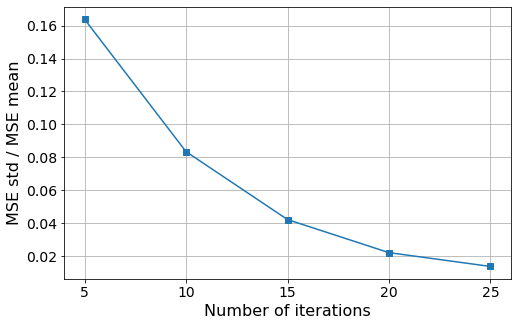

In [24]:
iteration_list = [5, 10, 15, 20, 25]

plot_IP_iteration_std(setting_dict,
                      iteration_list,
                      xlabel = "Iteration",
                      save = None)#"../img/inverse_problem/std_iteration_linear_Noise.png")

In [25]:
np.isin(1, list(return_dict["batch_particle_dict"].values()))

array(True)

In [26]:
list(return_dict["batch_particle_dict"].values())[0]

array([18, 38, 10, 44, 12, 15, 11,  4, 26, 29])

In [27]:
for batch, arr in enumerate(list(return_dict["batch_particle_dict"].values())):
    if 1 in arr:
        break
mean_squared_error(return_dict["A_batches"][batch] @ return_dict["param_dict"]["particle_{}".format(str(1))], return_dict["y_batches"][batch])

5.881757078955448

In [43]:
import pandas as pd
pd.DataFrame(param_init_dict).shape

(100, 50)

In [44]:
y_pred_init_dict = {}
for i in range(len(param_init_dict)):
    y_pred_init_dict["particle_{}".format(str(i+1))] = np.dot(A, param_init_dict["particle_{}".format(str(i+1))])
y_pred_init_dict["particle_1"].shape

(1000,)

In [45]:
X = pd.DataFrame(y_pred_init_dict)
X.shape

(1000, 50)

In [46]:
Xx = pd.DataFrame(param_init_dict)
Xx.shape

(100, 50)

In [47]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept = False).fit(X, y)
lmx = LinearRegression(fit_intercept = False).fit(Xx, x)

In [48]:
y_pred = lm.predict(X)
x_pred = lmx.predict(Xx)

In [49]:
mean_squared_error(y_pred, y)

1.560386972637083

In [183]:
a = np.dot(np.transpose(X), X)
b = np.dot(np.transpose(X), y)
beta = np.linalg.solve(a, b)
x_opt = np.dot(Xx, beta)
mean_squared_error(np.dot(A, x_opt), y)

12.199821182983882

In [173]:
mean_squared_error(x_pred, x)

0.23745847397901265

In [115]:
mean_squared_error(final_params, x)

0.6330730540505572

In [116]:
mean_squared_error(np.dot(A, x_pred), y)

118.77227394750251

In [117]:
mean_squared_error(x_opt, x)

0.2646907501120239

In [118]:
old_noise = np.dot(A, x) - y
new_noise = np.linalg.inv(np.transpose(A)@ A) @ np.transpose(A) @ old_noise
mean_squared_error(x + new_noise, x_pred)

0.17385260763622978

In [119]:
mean_squared_error(y, A @ (x+new_noise))

0.3821361092741286

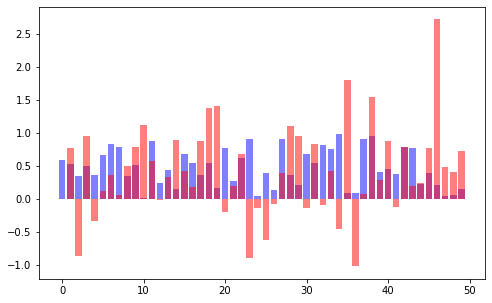

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
plt.bar(np.arange(x.shape[0])[:50], x[:50], alpha = 0.5, color = "b")
plt.bar(np.arange(final_params.shape[0])[:50], final_params[:50], alpha = 0.5, color = "r")
plt.show()

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([x, final_params])[1,0]

0.407873892018878

In [122]:
A = np.random.uniform(size = (1000, 200), low = 0, high = 1)
x = np.random.uniform(size = (A.shape[1], ))

def model_func(x):
    return np.dot(A, x)

noise = False

y, std = y_noise(model_func,
                 x, 
                 noise)

setting_dict = {"A": A,
                "model_func": model_func,
                "x": x,
                "y": y,
                "particles": 50,
                "epochs": 20,
                "batch_size" : 200,     # A.shape[0]           
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 3,
                "randomization": False,
                "loss": "mse"
                }
analysis_dict = {"disjoint_batch": True,
                 "batch_particle_connection": {"connect": True,
                                               "shuffle": "full",       # None, "full", "batch", "particle", "permute"
                                               "update_all": True},
                 "tikhonov": {"regularize": False,
                              "lambda": 15,
                              "reg_mse_stop": False},
                 "batch_evaluation": False}

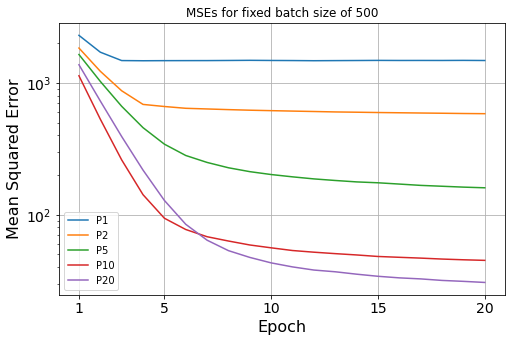

In [24]:
# Für den Approximationsfehler
# Beachte: Unterschiedlich große initiale Ensembles und demnach unterschiedlich zeitaufwändig

# Mit logarithmischer Skalierung

import matplotlib.pyplot as plt

if not analysis_dict["batch_particle_connection"]["connect"]:
    raise ValueError("Batch-particle connection must be true.")

batch_size = 500
particles_per_batch = [1, 2, 5, 10, 20]

start_epoch = 1
xlabel = "Epoch"
save = None

loss_evolution_dict = {}

for p in particles_per_batch:
    np.random.seed(42)
    setting_dict["batch_size"] = batch_size
    particles = int(setting_dict["A"].shape[0] / batch_size * p)
    setting_dict["particles"] = particles
    
    return_dict = enkf_linear_inverse_problem_analysis(setting_dict,
                                                       analysis_dict)
    loss_evolution_dict["P{}".format(p)] = return_dict["loss_evolution"]
    
xticks = np.linspace(start = 0,
                     stop = len(loss_evolution) - 1,
                     num = int((len(loss_evolution) - 1) / 5 + 1))
xticks = np.delete(xticks, np.where(xticks <= start_epoch))
xticks = np.append(xticks, [start_epoch])
    
plt.figure(figsize = (8,5))
for p in particles_per_batch:
    plt.plot(np.arange(len(loss_evolution_dict["P{}".format(p)]))[start_epoch:], 
             loss_evolution_dict["P{}".format(p)][start_epoch:],
             label = "P{}".format(p))
plt.legend()
plt.grid()
plt.xlabel(xlabel, fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.xticks(ticks = xticks, fontsize = 14)
plt.yticks(fontsize = 14)
plt.yscale("log")
if save is not None:
    plt.savefig(save)
plt.title("MSEs for fixed batch size of {}".format(batch_size))
plt.show()

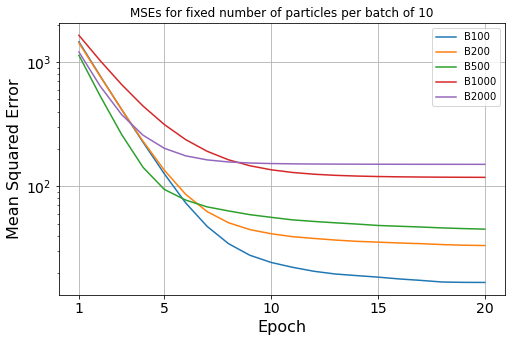

In [25]:
# Für den Approximationsfehler
# Beachte: Unterschiedlich große initiale Ensembles und demnach unterschiedlich zeitaufwändig

# Mit logarithmischer Skalierung

import matplotlib.pyplot as plt

if not analysis_dict["batch_particle_connection"]["connect"]:
    raise ValueError("Batch-particle connection must be true.")

batch_sizes = [100, 200, 500, 1000, 2000] 
particles_per_batch = 10

start_epoch = 1
xlabel = "Epoch"
save = None

loss_evolution_dict = {}

for b in batch_sizes:
    np.random.seed(42)
    setting_dict["batch_size"] = b
    particles = int(setting_dict["A"].shape[0] / b * particles_per_batch)
    setting_dict["particles"] = particles
    
    return_dict = enkf_linear_inverse_problem_analysis(setting_dict,
                                                       analysis_dict)
    loss_evolution_dict["B{}".format(b)] = return_dict["loss_evolution"]
    
xticks = np.linspace(start = 0,
                     stop = len(loss_evolution) - 1,
                     num = int((len(loss_evolution) - 1) / 5 + 1))
xticks = np.delete(xticks, np.where(xticks <= start_epoch))
xticks = np.append(xticks, [start_epoch])
    
plt.figure(figsize = (8,5))
for b in batch_sizes:
    plt.plot(np.arange(len(loss_evolution_dict["B{}".format(b)]))[start_epoch:], 
             loss_evolution_dict["B{}".format(b)][start_epoch:],
             label = "B{}".format(b))
plt.legend()
plt.grid()
plt.xlabel(xlabel, fontsize = 16)
plt.ylabel("Mean Squared Error", fontsize = 16)
plt.xticks(ticks = xticks, fontsize = 14)
plt.yticks(fontsize = 14)
plt.yscale("log")
if save is not None:
    plt.savefig(save)
plt.title("MSEs for fixed number of particles per batch of {}".format(particles_per_batch))
plt.show()

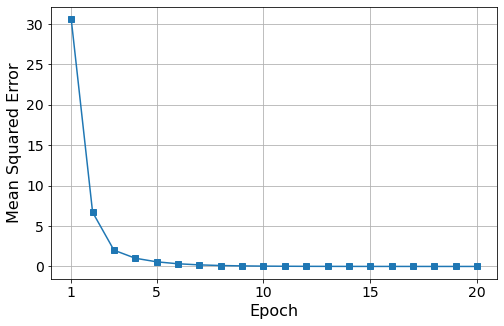

[0.025918261866953826,
 0.016376567053304432,
 0.010695341990468224,
 0.007270366228958053,
 0.005162693012660197,
 0.003827541792136832,
 0.002951594026890599,
 0.0023549900137744247,
 0.0019335089292038738,
 0.0016255355106583672]

In [51]:
setting_dict = {"model_func": model_func,
                "x": x,
                "y": y,
                "particles": 200,
                "iterations": 20,
                "noise": noise,
                "std": std,
                "h_0": 2,
                "epsilon": 0.5,
                "randomization": False
                }
final_params, loss_evolution, loss_evolution_single_dict = enkf_inverse_problem(setting_dict)
plot_IP_loss_evolution(loss_evolution,
                       start_iteration = 1,
                       xlabel = "Epoch",
                       save = None)
loss_evolution[-10:]

c:\users\morit\anaconda3\envs\master_thesis\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


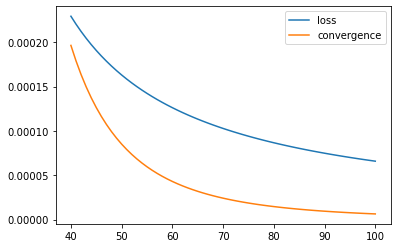

In [59]:
import matplotlib.pyplot as plt

conv = setting_dict["particles"] / np.arange(setting_dict["iterations"]+1)**3.75

plt.plot(np.arange(len(loss_evolution))[40:], loss_evolution[40:], label = "loss")
plt.plot(np.arange(len(loss_evolution))[40:], conv[40:], label = "convergence")
plt.legend()
plt.show()